In [2]:
'''Loading libraries'''
import pandas as pd 
import numpy as np 
from scipy.stats import gamma, dirichlet, beta, nbinom

'''
Notes: 
1) Gamma distribution: it's not clear in the paper if they are talking about scale or rate
'''


'''Important parameters I need to constantly change'''
k = 100


In [5]:
'''Loading dataset'''
filename = "C:\\Users\\raoki\\Documents\\GitHub\\project_spring2019\\Data\\data_final.csv"
#filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final.csv"
data = pd.read_csv(filename, sep=',')

In [34]:
'''Organizing columns names'''
lr = data.columns[[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
y = data.columns[3]
remove = data.columns[[0,1]]
data_complete = data.copy()

In [41]:
'''
Class to work with model parameters
I thought about using the default values as chain starting values, 
however, i encouter problems to change the size of arrays and matrices 
according with my currently k
'''
class parameters:
    def __init__(self, latent_v,latent_sk,latent_pj,latent_phi ,latent_tht, prediction):
        self.ln = latent_v #array with parameters that are only one number [0-c0,1-gamma0,2-eta,3-cj] 
        self.la_sk = latent_sk #array 
        self.la_pj = latent_pj #array
        self.lm_phi = latent_phi #matrix ()
        self.lm_tht = latent_tht #matrix  ()      
        self.p = prediction #array [intercept, gender, 15 cancer types, k genes]
 
'''Non informative prioris: dirichlet has only 1, gamma distribution with 1 average, etc'''
start = parameters(ln = [3,5,1,1],
                   la_sk = np.repeat(15,k), 
                   la_pj = np.repeat(0.5,data.shape[0]), 
                   lm_phi = np.repeat(,data.shape[0]).reshape(data.shape[1],k) 
                   lm_theta = np.repeat(1,data.shape[0]*k).reshape(k,data.shape[0]), 
                   p = np.concatenate(([-(k+2)], np.repeat(1,k+2))))


TypeError: __init__() missing 6 required positional arguments: 'latent_v', 'latent_sk', 'latent_pj', 'latent_phi', 'latent_tht', and 'prediction'

In [39]:
'''
Declaring my priori values: param.ln = [0-c0,1-gamma0,2-eta,3-cj], param.la_sk, param.la_pj, 
param.lm_phi, param.lm_tht and param.p = [] 
#j=sample of patients 
#v=genes
#k=latent
#UPDATE PARAM 
'''
def priori_l(param):
    k = len(param.la_sk)
    j = len(param.la_pj)
    #Prioris on the K plate
    s0 = 1 #define better numbers in the future
    t0 = 1 #define better numbers in the future 
    c0 = gamma.pdf(x=param.ln[0],a = s0,scale = t0) 
    a0 = 1 #define better numbers in the futureT
    b0 = 1 #define better numbers in the future
    gamma0 = gamma.pdf(x=param.ln[1],a = a0,scale = b0)
    sk = gamma.pdf(x=param.la_sk,a=gamma0/k,scale=c0)#array(k) gamma(3,5): mean is 15
    s0 = 1
    w0 = 1
    eta = gamma.pdf(x=param.ln[2], a = s0, scale = w0) #1
    phivk = dirichlet.pdf(param.lm_phi, np.repeat(eta,j)) #MATRIX #1
    priorik = np.log(c0)+np.log(gamma0)+np.log(sk).sum()+np.log(eta)+np.log(phivk).sum()
    #priories on the J plate
    a0 = 1 #define better numbers in the future
    b0 = 1 #define better numbers in the future
    pj = beta(x=param.la_pj,a=a0,b=b0) #same numbers? #array
    e0 = 1
    f0 = 1
    cj = gamma.pdf(param.ln[3], a = e0, scale = f0)
    priorij = np.log(pj).sum()+np.log(cj) #array    
    #prioris on K and J plate
    thetakj = gamma.pdf(x=param.lm_tht,a=sk,scale = cj) #MATRIX
    priorikj = np.log(thetakj).sum()
    return (priorik+priorij+priorikj)
    
def priori_p(param):
    '''
    #add prioris of logistic regression 
    #features are the theta_kj parameters and clinical info
    #one parameter for each latent variable + one parameter for each clinical features
    '''
    k = len(param.la_sk)
    mean = len(param.p)
    sd = 5
    mean.expend(1,np.repeat(1/15, 15))
    sd.expend(0.05,np.repeat(0.05/15,15))
    mean.expend(np.repeat(1,k))
    sd.expend(np.repeat(0.05,k))
    lr = normal.pdf(param.p,loc = mean, scale = sd) #loc/mean, scale/sd

In [ ]:
'''
Declare all the likelihood distributions in two separete functions
#_F represents the factor model likelihood and _P the prediction model likelihood
'''

#PASS DATA ONLY WITH RELEVANT COLUMNS FOR THIS PROBLEM 
def likelihood_F(param,dataf):
    '''phi(jk) x theta(kv) must be matrix , final dim is j patients x v genes '''
    phi_theta = np.matmul(param.lm_phi, param.lm_tht) 
    nvj = nbinom.pmf(dataf,n = phi_theta,p= pj) #matrix and array?
    return np.log(nvj).sum()

#PASS DATA ONLY WITH RELEVANT COLUMNS FOR THIS PROBLEM 
def likelihood_P(param, datap,y):
    '''[intercept, gender, 15 cancer types, k genes]'''
    xw = param.p[0]
    for i in np.arange(1,datap.shape[1]):
        xw = xw+param.p[i]*datap[datap.columns[i-1]]
    
    theta = t(param.lm_th)
    aux = datap.shape[1]
    for j in np.arange(0,theta.shape[1]):
        xw = xw + param.p[aux+j]*theta[theta.columns[j]]
    
    xwy = 0
    for k in np.arange(1,len(y)): 
        xwy = xwy+xw[k]*y[k]
    
    lxp = sum(-np.log(1+np.exp(xw)))
    #page 2 http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf
    #http://www.utstat.utoronto.ca/reid/sta2201s/2014/feb14-annotated-copy.pdf
    #https://www.statlect.com/fundamentals-of-statistics/logistic-model-maximum-likelihood
    return xwy + lxp

In [ ]:
'''
Definition of the posterior distribution and the split of the datasets
Note: the parameters are ok 
'''
def posterior(param,data_F,data_P,y,k):
    j = data.shape[0]
    return (likelihood_F(param,data_F)+likelihood_P(param, data_P,y)+priori_l(param)+priori_p(param)

In [43]:
'''
Proposal distribution
'''

#Proposal values for the parameters related to the factor model 
#Repete the parameters related to prediction and only propose
#new values for the factor analysys part
#output is the parameters class 
def proposal_f(current):
    new = parameters(np.random.normal(current.ln,0.05),
                     np.random.normal(current.la_sk,0.05),
                     np.random.normal(current.la_pj,0.05),
                     np.random.normal(current.lm_phi,0.5),
                     np.random.normal(current.lm_tht,0.5), 
                     current.p)
    return new

#Proposal values for the parameters related to logistic regression 
#Repete the parameters related to factor analysis part and propose
#new values for the logistc regression parameters 
#output is the parameters class 
def proposal_p(current):
    new = parameters(current.ln, current.la_sk, current.la_pj, 
                     current.lm_phi, current.lm_tht, 
                     np.random.normal(current.p,0.05))
    return new

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

In [ ]:
'''
Creatint the MCMC for the model
MCMC(
startvalue = initial value for the parameters
iterations = 
data = complete data with all columns 
k = number of latent variables
remove, lr, y = columns names to be removed, presente only in the logistic regression part and y
)
'''
def MCMC(startvalue, iterations, data,k, remove,lr,y):
    '''Splitting dataset'''
    data = data.drop(remove,axis = 1)
    data_P = data[lr]
    data_F = data.drop(lr,axis = 1)
    y = data[y]
    
    '''
    Initialization of the chains
    Note: chain_f has elements from chain_p and vice-versa. Take care to not use incorrectly
    '''     
    chain_f = []
    chain_p = []
    chain_f.append(startvalue)
    chain_p.append(startvalue)
    #chain1[0]=proposalvalues1(startvalue1)
    #chain2[0]=proposalvalues2(startvalue2)
    
    for i in np.arange(1,iterations):
        '''Factor Analysis - Latent Features'''
        #use chain_f or chain_p don't make difference here because
        #the only parameters changed are the logistic regression and 
        #they aren't used in the factor analysis part. 
        param_new_f = proposal_f(chain_f[i-1])
        param_cur_f = chain_f[i-1] 

        prob_f = np.exp(posterior(param_new,data_F,data_P,y,k)-posterior(param_curr,data_F,data_P,y,k))
        if np.random.uniform(0,1,1)<prob_f:
            chain_f.append(param_new_f)
        else:
            chain_f.append(param_cur_f) 
        '''Logistic Regression - Prediction'''
        #chain_f[i] has the most update latent parameters and haven't changed the 
        #prediction parameters from [i-1] iteration
        param_new_p = proposal_p(chain_f[i-1])
        param_cur_p = chain_f[i-1]
        
        prob_p = np.exp(posterior(param_new,data_F,data_P,y,k)-posterior(param_curr,data_F,data_P,y,k))
        if np.random.uniform(0,1,1)<prob_p:
            chain_p.append(param_new_p)
        else:
            chain_p.append(param_cur_p)     

        return chain_p, chain_f
        
        

In [ ]:
start = parameters(ln,la_sk, la_pj, lm_phi, lm_theta, 
                   p = np.concatenate(([-(k+2)], np.repeat(1,k+2))))
#output_p, output_f = MCMC(start,1000,data,100,remove,lr,y)

In [15]:
class test:
    def __init__(self, a=[1,2,3], b=0, c=len(a)):
        self.a = a
        self.b = b 
        self.c = c
        
a = test([1,1,1],2,3)
print(a.a,a.b,a.c)

a = test([1,1,1],2,3)
c = test([8,8,8],9,10)
b = [a,c]
print(b[1].b,b[0].b)
b.append(test())
print(b[0].b,b[1].b,b[2].b)


TypeError: object of type 'test' has no len()

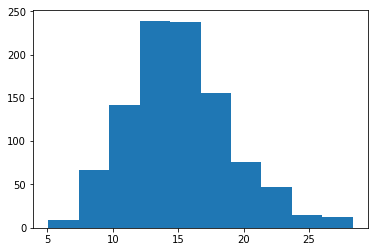

15.066065026754163


In [36]:
a = np.random.gamma(15,1, size = 1000)
import matplotlib.pyplot as plt
plt.hist(a)
plt.show()
print(a.mean())

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])